In [1]:
import sys
sys.path.append("..")

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
import torchvision
import torchvision.transforms as transforms
import tqdm
from torch.utils.data import Dataset
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import os
from src.dataset import *
from src.utils import *
import torch.optim as optim

import matplotlib
from torch.utils.data import DataLoader

## Model Class

In [3]:
class LeNet5_convnet(nn.Module):
    def __init__(self):

        super(LeNet5_convnet, self).__init__()

        # CL1: 3 x 144 x 256 --> 50 x 144 x 256
        self.conv1 = nn.Conv2d(3, 50, kernel_size=3, padding='same')

        # MP1: 50 x 144 x 256 --> 50 x 72 x 128 
        self.pool1 = nn.MaxPool2d(2, 2)

        # CL2: 50 x 72 x 128 --> 100 x 72 x 128
        self.conv2 = nn.Conv2d(50, 100, kernel_size=3, padding='same')

        # MP2: 100 x 72 x 128 --> 100 x 36 x 64
        self.pool2 = nn.MaxPool2d(2, 2)

        # LL1:   100 x 36 x 64 = 230400 -->  100
        self.linear1 = nn.Linear(230400, 100)
        
        # can be used in training
        self.dropout = nn.Dropout(0.2)

        # LL2:   100  -->  6
        self.linear2 = nn.Linear(100, 6)

    def forward(self, x, drop=False):

        # CL1: 3 x 144 x 256 --> 50 x 144 x 256
        x = self.conv1(x)
        x = F.relu(x)

        # MP1: 50 x 144 x 256 --> 50 x 72 x 128 
        x = self.pool1(x)

        # CL2: 50 x 72 x 128 --> 100 x 72 x 128
        x = self.conv2(x)
        x = F.relu(x)

        # MP2: 100 x 72 x 128 --> 100 x 36 x 64
        x = self.pool2(x)

        # LL1:   100 x 36 x 64 = 230400 -->  100
        x = x.view(-1, 230400)
        
        x = self.linear1(x)
        x = F.relu(x)
        if drop:
            x = self.dropout(x)
        
        # LL2:   100  -->  6
        x = self.linear2(x)

        return x

## Train function

In [4]:
# training function
def train(model, dataloader, optimizer, criterion, train_data, device):
    print("Training")
    model.train()
    counter = 0
    train_running_loss = 0.0
    train_running_error = 0.0
    for i, data in tqdm(
        enumerate(dataloader), total=int(len(train_data) / dataloader.batch_size)
    ):
        
        counter += 1
        data, target = data["image"].to(device), data["label"].to(device)
        optimizer.zero_grad()
        outputs = model(data, drop=False)
        # apply sigmoid activation to get all the outputs between 0 and 1
        outputs = torch.sigmoid(outputs)
        loss = criterion(outputs, target)
        train_running_loss += loss.detach().item()
        error = get_error( outputs.detach() , target, batch_size)
        train_running_error += error
        
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()

        
    train_loss = train_running_loss / counter
    total_error = train_running_error/counter
    return train_loss, total_error

## Validate function

In [5]:
def validate(model, dataloader, criterion, val_data, device):
    print("Validating")
    model.eval()
    counter = 0
    val_running_loss = 0.0
    val_running_error = 0.0
    with torch.no_grad():
        for i, data in tqdm(
            enumerate(dataloader), total=int(len(val_data) / dataloader.batch_size)
        ):
            counter += 1
            data, target = data["image"].to(device), data["label"].to(device)
            outputs = model(data)
            # apply sigmoid activation to get all the outputs between 0 and 1
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, target)
            val_running_loss += loss.item()
            error = get_error( outputs, target, batch_size)
            val_running_error += error
        val_loss = val_running_loss / counter
        val_error = val_running_error / counter
    return val_loss, val_error

In [6]:
# matplotlib.style.use("ggplot")
# initialize the computation device


## Set Parameters and Hyperparameters

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet5_convnet()
model = model.to(device)
display_num_param(model)
print(model)
lr = 0.0001
epochs = 10
batch_size = 32
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()

There are 23087206 (23.09 million) parameters in this neural network
LeNet5_convnet(
  (conv1): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=230400, out_features=100, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear2): Linear(in_features=100, out_features=6, bias=True)
)


## Load Train and Validation Data

In [8]:
# train dataset
train_data = ImageDataset(train=True)
# validation dataset
valid_data = ImageDataset(train=False)
# train data loader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# validation data loader
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)



Number of training images: 2065
Number of test images: 365


## Training

In [9]:
train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, total_epoch_error = train(
        model, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss, valid_epoch_error = validate(model, valid_loader, criterion, valid_data, device)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print("Train Error: ", total_epoch_error)
    print(f"Val Loss: {valid_epoch_loss:.4f}")
    print(f"Val Error: ", valid_epoch_error)
    

Epoch 1 of 10
Training


  0%|                                                                                           | 0/64 [00:00<?, ?it/s]C:\Users\Rishabh\anaconda3\envs\deeplearn_course\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
65it [00:05, 12.23it/s]                                                                                                


Validating


12it [00:00, 21.07it/s]                                                                                                


Train Loss: 0.4764
Train Error:  22.139423604194935
Val Loss: 0.5997
Val Error:  26.909723008672398
Epoch 2 of 10
Training


65it [00:03, 17.43it/s]                                                                                                


Validating


12it [00:00, 21.15it/s]                                                                                                


Train Loss: 0.3293
Train Error:  13.509615728488335
Val Loss: 0.5999
Val Error:  25.000000496705372
Epoch 3 of 10
Training


65it [00:03, 17.29it/s]                                                                                                


Validating


12it [00:00, 20.50it/s]                                                                                                


Train Loss: 0.2401
Train Error:  9.18269252547851
Val Loss: 0.6301
Val Error:  23.567709202567737
Epoch 4 of 10
Training


65it [00:03, 17.21it/s]                                                                                                


Validating


12it [00:00, 22.00it/s]                                                                                                


Train Loss: 0.1748
Train Error:  6.346154026687145
Val Loss: 0.7555
Val Error:  24.522570023934048
Epoch 5 of 10
Training


65it [00:03, 16.88it/s]                                                                                                


Validating


12it [00:00, 18.77it/s]                                                                                                


Train Loss: 0.1300
Train Error:  4.399038581893994
Val Loss: 0.8305
Val Error:  26.21527872979641
Epoch 6 of 10
Training


65it [00:03, 16.81it/s]                                                                                                


Validating


12it [00:00, 19.85it/s]                                                                                                


Train Loss: 0.0985
Train Error:  3.0128206112063847
Val Loss: 0.8980
Val Error:  24.522570210198563
Epoch 7 of 10
Training


65it [00:03, 16.90it/s]                                                                                                


Validating


12it [00:00, 19.72it/s]                                                                                                


Train Loss: 0.0823
Train Error:  2.491987249455773
Val Loss: 0.8805
Val Error:  25.868055907388527
Epoch 8 of 10
Training


65it [00:03, 16.63it/s]                                                                                                


Validating


12it [00:00, 19.44it/s]                                                                                                


Train Loss: 0.0580
Train Error:  1.5064102991555746
Val Loss: 1.0303
Val Error:  24.392361876865227
Epoch 9 of 10
Training


65it [00:04, 15.70it/s]                                                                                                


Validating


12it [00:00, 18.68it/s]                                                                                                


Train Loss: 0.0501
Train Error:  1.2019231027135482
Val Loss: 1.1826
Val Error:  27.300348008672398
Epoch 10 of 10
Training


65it [00:04, 14.51it/s]                                                                                                


Validating


12it [00:00, 17.39it/s]                                                                                                

Train Loss: 0.0355
Train Error:  0.8894230984151363
Val Loss: 1.2063
Val Error:  25.60764004786809


## Testing

In [10]:
actors = np.array(CLASSES)
print('actors: ', actors)
# prepare the test dataset and dataloader
test_data = ImageDataset(train=False)
print(test_data[0]['image'].shape, test_data[0]['label'].shape)
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

actors:  ['chandler' 'joey' 'monica' 'phoebe' 'rachel' 'ross']
Number of test images: 365
torch.Size([3, 144, 256]) torch.Size([6])


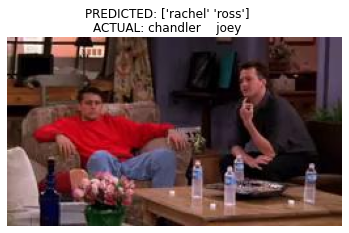

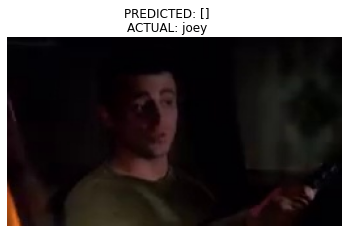

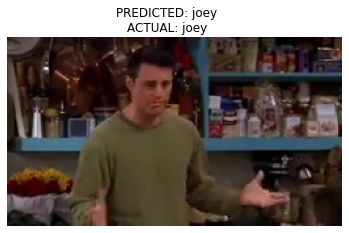

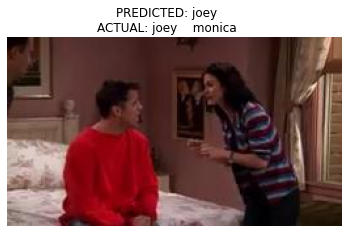

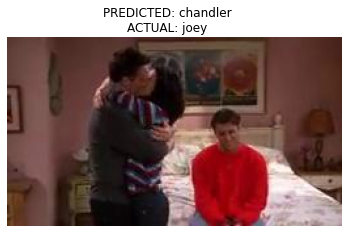

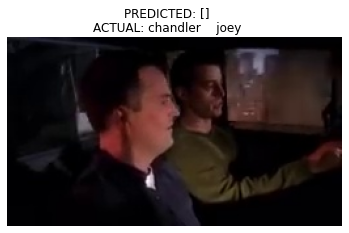

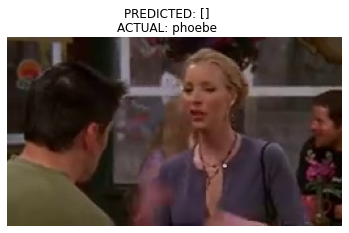

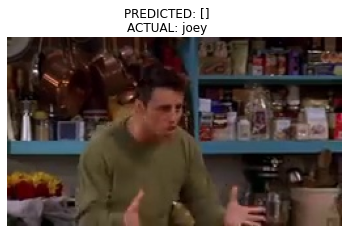

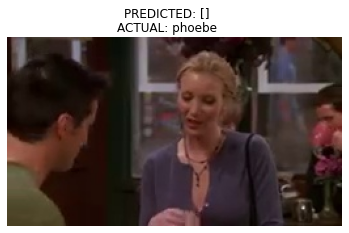

Test Error:  27.014652615065103


In [11]:
model.eval()
test_running_error = 0.0
output_list= []
target_list = []
for counter, data in enumerate(test_loader):
    
    image, target = data["image"].to(device), data["label"]
    # get all the index positions where value == 1
    target_indices = [i for i in range(len(target[0])) if target[0][i] == 1]

    # get the predictions by passing the image through the model
    outputs = model(image, False)
    outputs = torch.sigmoid(outputs)
    outputs = outputs.detach().cpu()
    lab = torch.where(outputs>=0.5,1,0)[0]
    pred = torch.where(lab==1)
    error = get_error( outputs, target, 1)
    
    output_list.append(outputs.numpy())
    target_list.append(target.numpy())
    
    test_running_error += error
    
    string_predicted = ""
    string_actual = ""
    for i in range(len(pred)):
        string_predicted += f"{actors[pred[i]]}    "
    for i in range(len(target_indices)):
        string_actual += f"{actors[target_indices[i]]}    "
        
    if 10< counter < 20:
        image = image.squeeze(0)
        image = image.detach().cpu().numpy()
        image = np.transpose(image, (1, 2, 0))
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"PREDICTED: {string_predicted}\nACTUAL: {string_actual}")
        plt.show()
    
test_error = test_running_error / counter
print(f"Test Error: ", test_error)

out = np.array(output_list).squeeze(axis=1)
tar = np.array(target_list).squeeze(axis=1)



In [12]:
f1 = get_f1_score(tar, out)
precision = get_precision_score(tar, out)
recall = get_recall_score(tar, out)
print("f1 score: ", f1)
print('Precision: ', precision)
print('Recall: ', recall)

f1 score:  0.32298108284409655
Precision:  0.38584474885844744
Recall:  0.3085388127853881


C:\Users\Rishabh\anaconda3\envs\deeplearn_course\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Results with dropout
#### Test Results:

Test Error:  0.32233677666211863

f1 score:  0.16344307270233194

precision:  0.1779835390946502

recall:  0.17973251028806583

#### Training Epoch 10 Stats:
Train Loss: 0.0720

Train Error:  0.02434329779656685

Val Loss: 1.0906

Val Error:  0.2890625107102096


### Results without dropout
#### Training Epoch 10 Stats:
Test Error:  0.2907216556907929

f1 score:  0.270615324319028

precision:  0.28497942386831276

recall:  0.2894718792866941

#### Epoch 10 Results:
Train Loss: 0.0528

Train Error:  0.014379529282450676

Val Loss: 1.1573

Val Error:  0.2692057378590107